hello - I think we should have a directed network whereby each edge x->y indicates prob y is used given x is




In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
import math

#Load in CulinaryDB database
recipeDetails = pd.read_csv(filepath_or_buffer='./Data/01_Recipe_Details.csv', sep=',', encoding='latin')
ing = pd.read_csv(filepath_or_buffer='./Data/02_Ingredients.csv', sep=',', encoding='latin')
compIng = pd.read_csv(filepath_or_buffer='./Data/03_Compound_Ingredients.csv', sep=',', encoding='latin')
recipeIng = pd.read_csv(filepath_or_buffer='./Data/04_Recipe-Ingredients_Aliases.csv', sep=',', encoding='latin')

In [2]:
#Record number of ingredients (compound and simple)
ingShape = ing.shape
compIngShape = compIng.shape
totIng = ingShape[0] + compIngShape[0]

#Record Number of Regions
regionList = np.unique(recipeDetails['Cuisine'].values.tolist())
regions = regionList.shape[0]

#Quick map from region name to layer of matrix
areaCode = {}
for i in range(regions):
    areaCode[regionList[i]] = i
    
#Quick map from ingredient code to node number
ingCode = {}
ingredients = ing['Entity ID']
for i in range(ingShape[0]):
    ingCode[ingredients[i]] = i
ingredients = compIng['entity_id']
for i in range(compIngShape[0]):
    ingCode[ingredients[i]] = ingShape[0] + i

#Create adjacency matrix for each region
adjMx = [0] * regions
for i in range(regions):
    adjMx[i] = np.zeros([totIng,totIng])

#Store dist of ingredient list length
ingDist = []
for i in range(regions):
    ingDist.append([])
    
#Find recipe pairings
fileLength = recipeIng.shape[0]
recipeCount = recipeDetails.shape[0]
startPoint = 0;
#Iterate through each recipe
for i in range(recipeCount):
    #Find which ingredients are in the recipe
    ingredientList = []
    ingLength = 0;
    while (recipeIng.iloc[startPoint,0] == i+1):
        ingredientList.append(ingCode[recipeIng.iloc[startPoint,3]])
        startPoint = startPoint + 1
        ingLength = ingLength + 1
        if (startPoint == fileLength):
            break
    #Check region
    region = areaCode[recipeDetails.iloc[i,3]]
    
    #Add recipe ingredient list length distribution
    ingDist[region].append(ingLength)
    
    #For each ingredient add one to frequency of occurrence together in adj mx
    count = len(ingredientList)
    for j in range(count):
        for k in range(count):
            adjMx[region][ingredientList[j]][ingredientList[k]] = adjMx[region][ingredientList[j]][ingredientList[k]] + 1

G = [] #List of graphs
nodeSize = [] #Number of recipes each node is in

goodNodes = []
goodSizes = []
edgeData = []
widths = []
edges = []

#Create Weights
for i in range(regions):
    nodeSizeRegion = []
    for j in range(totIng):
        quantity = adjMx[i][j][j]
        #Record how often ingredient used
        nodeSizeRegion.append(adjMx[i][j][j])
        #for k in range(totIng):
        #    if (quantity < 0.5):
        #        adjMx[i][j][k] = 0
        #    else:
        #        adjMx[i][j][k] = adjMx[i][j][k] / quantity
                #adjMx[i][j][k] = math.log(adjMx[i][j][k]) - math.log(quantity) - math.log(adjMx[i][k][k])
        adjMx[i][j][j] = 0
    
    #Create Weighted Digraph
    G.append(nx.from_numpy_matrix(adjMx[i]))
    nodeSize.append(nodeSizeRegion)
    
    #Record ingredients actually used
    goodNodesRegion = []
    goodSizesRegion = []
    for j in range(totIng):
        if (nodeSize[i][j] > 0.5):
            goodNodesRegion.append(j)
            goodSizesRegion.append(nodeSize[i][j]+150)
    
    goodNodes.append(goodNodesRegion)
    goodSizes.append(goodSizesRegion)
    
    #Record edge weights for edges
    edgeData.append(list(G[i].edges.data('weight')))
    edgesRegion = []
    widthsRegion = []
    for edge in edgeData[i]:
        edgesRegion.append(edge[0:2])
        widthsRegion.append(edge[2] /10)
    
    edges.append(edgesRegion)
    widths.append(widthsRegion)

nodeList = list(G[0])

#Create list of ingredient labels for each node
labels = {}
for j in range(totIng):
    if (j < 930):
        labels[j] = ing['Aliased Ingredient Name'][j]
    else:
        labels[j] = compIng['Compound Ingredient Name'][j-930]
        
#Save Properly for MATLAB WSBM code
for i in range(len(G)):
    A = nx.adjacency_matrix(G[i])
    np.savetxt(".\\adjMx\\adjMx" + str(i) + ".txt", A.todense(),delimiter= " ")

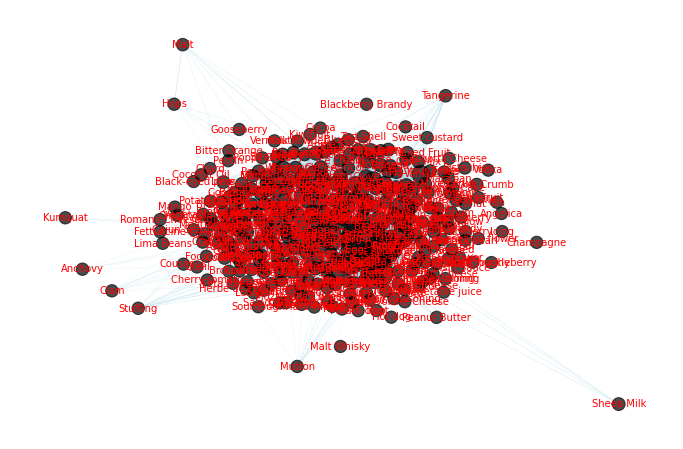

In [44]:
region = 2

H = G[region].subgraph(goodNodes[region])

hLabels = {key: labels[key] for key in list(H.nodes)}

pos = nx.kamada_kawai_layout(H)

plt.figure(figsize=(12,8))
nx.draw_networkx_nodes(H,pos,nodelist = goodNodes[region],node_size = goodSizes[region],node_color='black',alpha=0.7)
nx.draw_networkx_edges(H,pos,edgelist = edges[region],width=widths[region],edge_color='lightblue',alpha=0.6)
nx.draw_networkx_labels(H,pos,labels=hLabels,font_color='red',font_size=10,font_family='sans-serif')
plt.box(False)
plt.show()

In [11]:
areaCode

{'Africa': 0,
 'Australia & NZ': 1,
 'British Isles': 2,
 'Canada': 3,
 'Caribbean': 4,
 'China': 5,
 'DACH Countries': 6,
 'Eastern Europe': 7,
 'France': 8,
 'Greece': 9,
 'Indian Subcontinent': 10,
 'Italy': 11,
 'Japan': 12,
 'Korea': 13,
 'Mexico': 14,
 'Middle East': 15,
 'Misc.: Belgian': 16,
 'Misc.: Central America': 17,
 'Misc.: Dutch': 18,
 'Misc.: Portugal': 19,
 'Scandinavia': 20,
 'South America': 21,
 'South East Asia': 22,
 'Spain': 23,
 'Thailand': 24,
 'USA': 25}

# I think a little bit of investigating?

In [3]:
#Construct new graph from MATLAB data
Gnew = []

#Load in blockstructure data
thetaE = np.loadtxt(".\params\\thetaE.txt",delimiter = ",")
thetaW = np.loadtxt(".\params\\thetaW.txt", delimiter = ",")
z = np.loadtxt(".\params\\z.txt",dtype =int, delimiter = ",")
newRegionList = np.loadtxt(".\params\\regions10.txt",dtype =int, delimiter = ",")

#Generate each layer
for k in range(int(len(z) / totIng)): 
    Gnew.append(nx.Graph())
    Gnew[k].add_nodes_from(range(totIng))
    for i in range(totIng):
        for j in range(i+1,totIng):
            edge = np.random.random_sample()
            if (edge < thetaE[z[i]-1][z[j]-1]):
                Gnew[k].add_edge(i,j,weight = np.random.poisson(thetaW[z[i]-1][z[j]-1]) + 1)


In [4]:
print("Layer   AreaCode         Area")
for i in areaCode:
    for j in range(len(newRegionList)):
        if areaCode[i] == newRegionList[j]:
            print(str(j) + "          " + str(areaCode[i]) + "          " + i)

Layer   AreaCode         Area
0          0          Africa
1          2          British Isles
2          7          Eastern Europe
3          10          Indian Subcontinent
4          13          Korea
5          21          South America


In [5]:
def rdmWalkPort(G,x0,maxIng,gamma):
    x = [x0]
    ing = []
    weight = []
    total = []
    p = []
    invWeight = []
    for i in range(maxIng-1):
        choice = np.random.choice([0,1],p=[gamma, 1-gamma])
        
        nextIng = []
        nextWeight = []
        for u,v,w in G.edges(x[i],data=True):
            nextWeight.append(w['weight'])
            nextIng.append(v)

        total.append(sum(nextWeight))
        ing.append(nextIng)
        weight.append(nextWeight)
        if (total[i] == 0):
            invWeight.append(0)
        else:
            invWeight.append(1/total[i])
        
        if choice == 1:
            totInvWeight = sum(invWeight)
            if totInvWeight == 0:
                #return x
                x.append(np.random.choice(G.nodes()))
            else:
                prob = [w/totInvWeight for w in invWeight]

                j = np.random.choice(range(len(x)),p=prob)
                #if ing[j] == []:
                #    return x
                newIng = np.random.choice(ing[j],p=[w/total[j] for w in weight[j]])
                #if newIng in x:
                #    return x
                x.append(newIng)
        else:
            x.append(np.random.choice(G.nodes()))
    return x

def rdmWalkPort(G,x0,maxIng,gamma):
    return modRdmWalkPort([G],0,x0,maxIng,gamma,0)

In [6]:
#Modified Random Walk Proposed
def modRdmWalkPort(G,region,x0,maxIng,gamma,delta):
    #x is an ingredient list
    x = [x0]
    
    #storing info on nerby ingredients as well as weights of edges for each ingredient in list x
    ing = [[] for _ in range(len(G))]
    weight = [[] for _ in range(len(G))]
    total = [[] for _ in range(len(G))]
    invWeight = [[] for _ in range(len(G))]
    
    #Adding ingredients to our list
    for i in range(maxIng-1):
        
        #Deciding whether to choose randomly, change region or just pick an ingredient
        choice = np.random.choice([0,1,2],p=[gamma,delta, 1-gamma-delta])
        
        #For the new ingredient added we have to store the information found
        for j in range(len(G)):
            #Getting adjacent ingredient and edge weight info for region j
            nextIng = []
            nextWeight = []
            for u,v,w in G[j].edges(x[i],data=True):
                nextWeight.append(w['weight'])
                nextIng.append(v)
           
            #Storing all information 
            total[j].append(sum(nextWeight))
            ing[j].append(nextIng)
            weight[j].append(nextWeight)
            
            #Storing inverted total weight (making sure to account for when the weight sums to zero)
            if (total[j][i] < pow(10,-6)):
                invWeight[j].append(0)
            else:
                invWeight[j].append(1/total[j][i])
        
        #Updating region (if applicable)
        if choice == 1:
            newRegion = np.random.choice(range(len(G)-1))
            if newRegion < region:
                region = newRegion
            else:
                region = newRegion +1
        
        if choice == 0:
            #Choosing random ingredient if applicable
            x.append(np.random.choice(G[region].nodes()))
        else:
            #Summing all inverted weights
            totInvWeight = sum(invWeight[region])
            if totInvWeight == 0:
                x.append(np.random.choice(G[region].nodes()))
            else:
                #Picking an ingredient from list x with probability proportional to inverse of
                #sum of weights on edges leaving it
                prob = [w/totInvWeight for w in invWeight[region]]
                j = np.random.choice(range(len(x)),p=prob)

                #Picking ingredient neighbouring our chosen ingredient from list x
                newIng = np.random.choice(ing[region][j],p=[w/total[region][j] for w in weight[region][j]])
                x.append(newIng)
            
    return x

#Random Walk for a single layer
def rdmWalkPort(G,x0,maxIng,gamma):
    return modRdmWalkPort([G],0,x0,maxIng,gamma,0)

In [27]:
region = 3
x = modRdmWalkPort(Gnew,region,np.random.choice(range(totIng)),30,0.1,0)

for val in set(x):
    print(labels[val])

Mountain yam
Grass pea
Shea tree
Lupine
Dock


In [7]:
def recipeLenDist(G,L,iterNo,gamma):
    lengthDist = []
    for j in range(iterNo):
        x = rdmWalkPort(G,np.random.choice(G.number_of_nodes()),L,gamma)
        #if len(set(x)) > 1:
        lengthDist.append(len(set(x)))
    return lengthDist

In [8]:
def modRecipeLenDist(G,L,iterNo,gamma,delta):
    lengthDist = []
    for j in range(iterNo):
        x = modRdmWalkPort(G,np.random.choice(range(len(G))),np.random.choice(G[0].number_of_nodes()),L,gamma,delta)
        #if len(set(x)) > 1:
        lengthDist.append(len(set(x)))
    return lengthDist

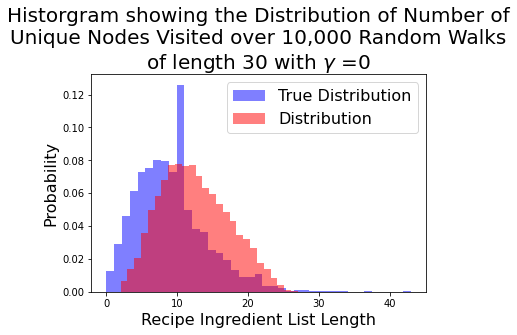

In [10]:
gamma = 0
length = 30
region = 5
delta = 0.1

ingDistNew = []

for i in newRegionList:
    ingDistNew = ingDistNew + ingDist[i]

lengthDist = modRecipeLenDist(Gnew,length,10000,gamma,delta)

plt.hist(ingDistNew,len(set(ingDistNew)), density=True, facecolor='b', alpha=0.5,label='True Distribution')
plt.hist(lengthDist, len(set(lengthDist)), density=True, facecolor='r', alpha=0.5,label='Distribution')
plt.xlabel('Recipe Ingredient List Length', fontsize=16)
plt.ylabel('Probability', fontsize=16)
plt.title('Historgram showing the Distribution of Number of\nUnique Nodes Visited over 10,000 Random Walks\nof length ' + str(length) + ' with $\gamma$ =' + str(gamma), fontsize=20)
plt.legend(prop={"size":16})
plt.savefig('..\Plots\lenDist' + '_g' + str(gamma) + '_d' + str(delta) + '_L' + str(length) + '.png',bbox_inches='tight')
plt.show()

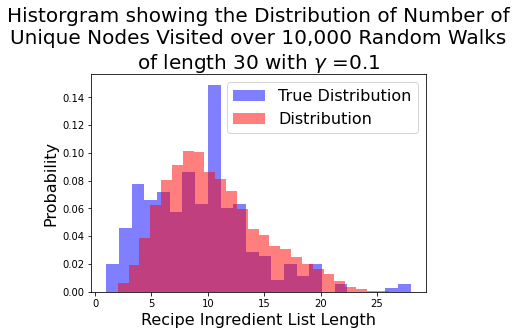

In [19]:
gamma = 0.1
length = 30
region = 5

lengthDist = recipeLenDist(Gnew[region],length,10000,gamma)

plt.hist(ingDist[newRegionList[region]],len(set(ingDist[newRegionList[region]])), density=True, facecolor='b', alpha=0.5,label='True Distribution')
plt.hist(lengthDist, len(set(lengthDist)), density=True, facecolor='r', alpha=0.5,label='Distribution')
plt.xlabel('Recipe Ingredient List Length', fontsize=16)
plt.ylabel('Probability', fontsize=16)
plt.title('Historgram showing the Distribution of Number of\nUnique Nodes Visited over 10,000 Random Walks\nof length ' + str(length) + ' with $\gamma$ =' + str(gamma), fontsize=20)
plt.legend(prop={"size":16})
plt.savefig('..\Plots\lenDist' + str(region) + '_' + str(gamma) + '_' + str(length) + '.png',bbox_inches='tight')
plt.show()

In [10]:
newRegionList

array([ 0,  2,  7, 10, 13, 21])

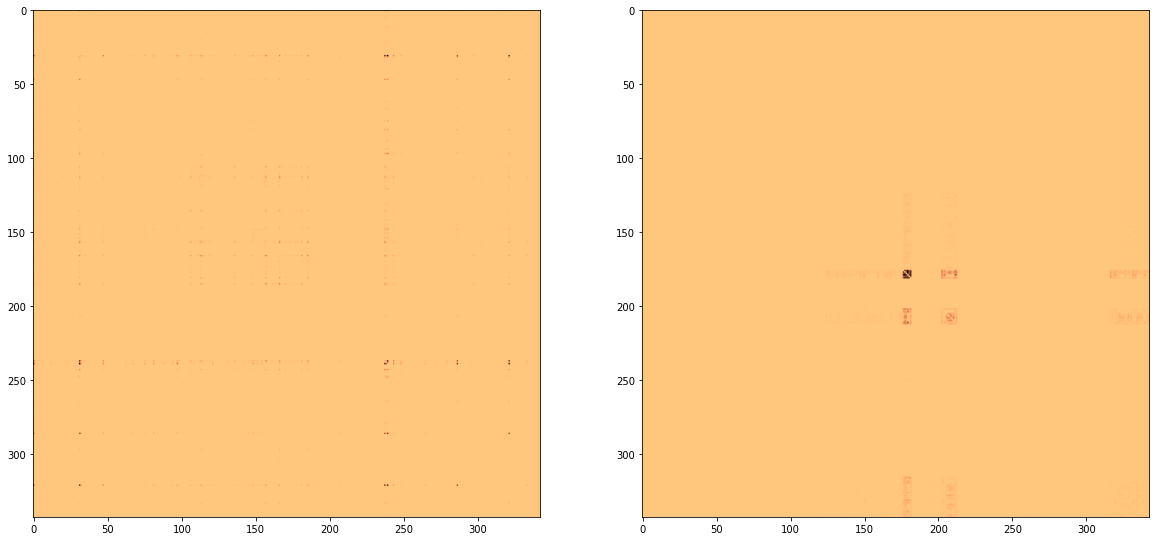

In [14]:
region = 1

group = [[],[],[],[],[],[],[],[],[],[]]
for i in range(1033):
    group[z[i+1033*region]-1].append(i)
blockStructure = []

for g in group:
    blockStructure = blockStructure + g

remove = [node for node,degree in dict(G[newRegionList[region]].degree()).items() if degree == 0]

defaultStructure = list(range(1033))

for i in remove:
    blockStructure.remove(i)
    defaultStructure.remove(i)

adjNew = nx.adjacency_matrix(G[newRegionList[region]], nodelist=blockStructure,weight='weight')

adjOld = nx.adjacency_matrix(G[newRegionList[region]],nodelist=defaultStructure,weight='weight')

adjAdaptedOld = nx.adjacency_matrix(Gnew[region],nodelist=defaultStructure,weight='weight')
adjAdaptedNew = nx.adjacency_matrix(Gnew[region],nodelist=blockStructure,weight='weight')

fig = plt.figure(figsize=(20,40))

ax1 = fig.add_subplot(121)
ax1.imshow(adjOld.todense(), cmap="copper_r")

ax2 = fig.add_subplot(122)
ax2.imshow(adjNew.todense(), cmap="copper_r")

plt.savefig('block' + str(region) + '.png',bbox_inches='tight')
plt.show()

In [102]:
for dist in newRegionList:
    print(max(ingDist[dist]))

42
30
25
42
43
28


In [9]:
newRegionList[region]

0

In [10]:
remove = [node for node,degree in dict(G[newRegionList[region]].degree()).items() if degree == 0]

In [14]:
ingCode[781]

755

In [17]:
labels[755]

'Sugar'

{0: Text(-0.8593772680081546, -0.05852513987194643, 'Chickpea'),
 1: Text(0.8968105179512604, 0.7423095009856889, 'Cayenne'),
 2: Text(0.27016621234917687, 0.1513645011361117, 'Mushroom'),
 3: Text(-0.12920600412695385, -0.6513789126302357, 'Potato'),
 4: Text(-0.9029938752890483, -0.43486188250359603, 'Flour'),
 5: Text(-0.27539958287628097, 0.653027608945029, 'Salt'),
 6: Text(1.0, -0.40193567606105135, 'Egg')}

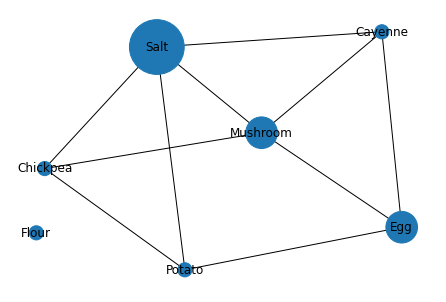

In [34]:
G = nx.gnp_random_graph(7,0.4)
pos = nx.kamada_kawai_layout(G)
size = []
for x in G.nodes():
    size.append(np.random.choice([200,1000,80,3000]))
    
gLabels = {0: "Chickpea", 1: "Cayenne", 2: "Mushroom", 3: "Potato",4: "Flour",5: "Salt", 6: "Egg"};
nx.draw(G,pos,node_size = size)
nx.draw_networkx_labels(G,pos,labels=gLabels)

In [19]:
size

[200, 80, 1000, 3000, 200, 200, 1000]

{0: Text(-0.8593772680081546, -0.05852513987194643, 'Chickpea'),
 1: Text(0.8968105179512604, 0.7423095009856889, 'Cayenne'),
 2: Text(0.27016621234917687, 0.1513645011361117, 'Mushroom'),
 3: Text(-0.12920600412695385, -0.6513789126302357, 'Potato'),
 4: Text(-0.9029938752890483, -0.43486188250359603, 'Flour'),
 5: Text(-0.27539958287628097, 0.653027608945029, 'Salt'),
 6: Text(1.0, -0.40193567606105135, 'Egg')}

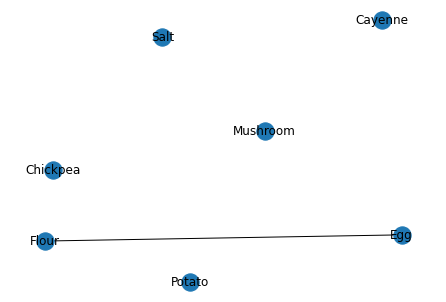

In [36]:
G = nx.gnp_random_graph(7,0.2)
nx.draw(G,pos)
nx.draw_networkx_labels(G,pos,labels=gLabels)